In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [2]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0009.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [3]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

In [4]:
def SimStart2(bsolar,msolar,iJovian):
    '''
    Starts the simulation. Adds all particles
    
    Arguments:
    
    bsolar: list of strs
    
    The names of the bodies added. Typically: '1','2','3','4', 'Jupiter','Io','Ananke'. 'Jupiter' must be added
    last followed by the satellites in the system
    
    msolar: list of floats
    
    The masses of the bodies in bsolar. Must be at the order of bsolar
    
    iJovian: list, int
    
    The indexes (+1) that the satellites in the solar system have in bsolar
    
    '''
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    sim.add(m=1.)
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t)
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            if 'Jupiter' in bsolar:
                ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
            else:
                ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1])
    sim.move_to_com()
    jupcom = sim.calculate_com(first=8)
    print(jupcom-sim.particles[3])
    return ps,sim

In [5]:
def Integrator(bsolar,msolar,iJovian,body1,body2):
    '''
    Integrates the system. If body1 or body2 refer to the Jupiter Barycenter, while there are bodies in the Jovian system
    teh function will compute the barycenter in the simulation
    
    Arguments:
    
    bsolar
    msolar
    iJovian
    
    body1 and body2: name in str
    
    The spice names of the bodies that we want to look into to check the error of our integrator
    
     '''
    ps,sim = SimStart2(bsolar,msolar,iJovian)
    xm = []
    ym = []
    zm = []
    xan = []
    yan = []
    distance = []
    Nout = 1000
    year = 365.25 # days
    day = 86400 # s
    tmax = 40*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        if body2 == '5' and len(iJovian)>1 :
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(ps[bsolar.index(body1)+1].x - jupcom.x)
                yan.append(ps[bsolar.index(body1)+1].y - jupcom.y)
        elif body1 == '5' and len(iJovian)>1:
                jupcom = sim.calculate_com(first=bsolar.index('Jupiter')+1)
                xan.append(jupcom.x - ps[0].x)
                yan.append(jupcom.y - ps[0].y)
        else:    
                xan.append(0)
                yan.append(0)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
        zm.append(xyz[2])
        distance.append(np.sqrt(xm[i]**2 + ym[i]**2 + zm[i]**2))
    return x,y,xm,ym,times,distance,xan,yan

In [6]:
def ErrorSource(bsolar,mass,iJovian,body1,body2):
    '''
    Returns the error of the chosen bodies as well as the entire system
    
    '''
    x,y,xm,ym,times,distance,xan,yan = Integrator(bsolar,mass,iJovian,body1,body2)
    if (body2 == '5' or body1 == '5') and len(iJovian)>1:
        dist1 = np.array(xan)
        dist2 = np.array(yan)
    elif body2 == 'Sun':
        temp = 0
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
    else:
        temp = bsolar.index(body2)+1
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
    print(len(dist1),len(xm),len(x[0]))
    return np.array(dist1-xm),np.array(dist2-ym),times,distance,x,y

In [7]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420
GMMoon = 27068703.151194

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06
GMJupiterB310 = 1.267127641334463E+08

In [8]:
MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MEarth = GMEarth/GMSun
MMoon = GMMoon/GMSun
MMarsB = GMMarsB/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
MSaturnB = GMSaturnB/GMSun
MUranusB = GMUranusB/GMSun
MNeptuneB = GMNeptuneB/GMSun
MIo = GMIo/GMSun
MEuropa = GMEuropa/GMSun
MGanymede = GMGanymede/GMSun
MCallisto = GMCallisto/GMSun
MAmalthea = GMAmalthea/GMSun

In [60]:
maxerr = []
distances = []

Ellara

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 23.7 s, sys: 32 ms, total: 23.7 s
Wall time: 23.8 s


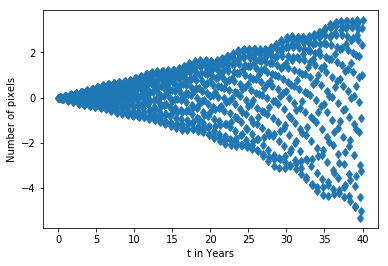

In [61]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Elara'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Elara','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Himalia

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605794464 y=1.5680852517748194 z=0.8077495115561952 vx=-0.0180486103054985 vy=-0.006212704363887826 vz=-0.0026338012761316473>
1000 1000 1000


Text(0.5,0,'t in Years')

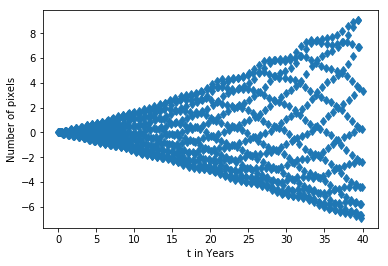

In [62]:
GMHimalia = 1.380080696078966E-01
MHimalia = GMHimalia/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto-GMHimalia)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Himalia'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,MHimalia ],[9,10,11,12,13,14,15],'Himalia','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Pasiphae

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.5 s, sys: 35.2 ms, total: 22.5 s
Wall time: 22.5 s


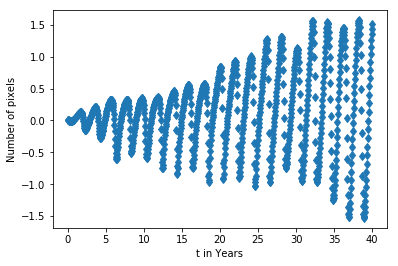

In [63]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Pasiphae'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Pasiphae','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Sinope

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.6 s, sys: 21.8 ms, total: 22.6 s
Wall time: 22.6 s


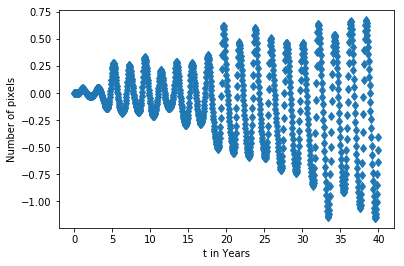

In [64]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Sinope'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Sinope','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Lysithea

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.6 s, sys: 20.9 ms, total: 22.6 s
Wall time: 22.6 s


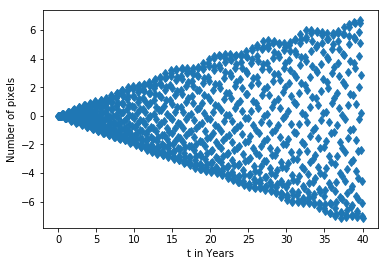

In [65]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Lysithea'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Lysithea','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Carme

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.7 s, sys: 23.5 ms, total: 22.7 s
Wall time: 22.7 s


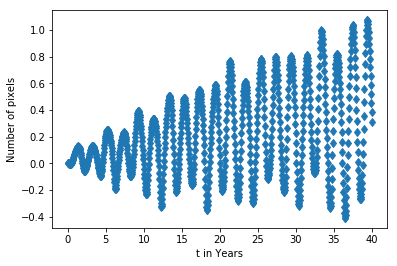

In [66]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Carme'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Carme','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Ananke

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.6 s, sys: 25.8 ms, total: 22.6 s
Wall time: 22.6 s


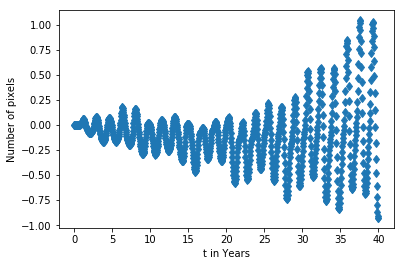

In [67]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Ananke'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Ananke','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Leda

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.5 s, sys: 25.6 ms, total: 22.5 s
Wall time: 22.5 s


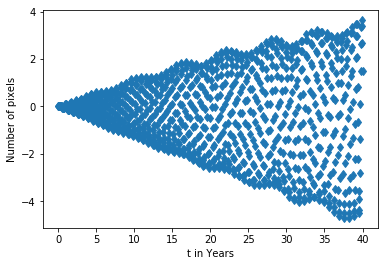

In [68]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Leda'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Leda','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Callirrhoe

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.5 s, sys: 22.8 ms, total: 22.6 s
Wall time: 22.6 s


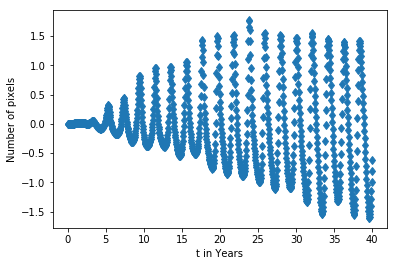

In [69]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Callirrhoe'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Callirrhoe','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Themisto

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.5 s, sys: 23.2 ms, total: 22.5 s
Wall time: 22.5 s


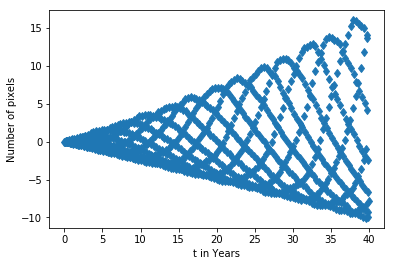

In [70]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Themisto'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Themisto','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

Magaclite

<rebound.Particle object, m=0.0009517514775406745 x=-5.363981605793089 y=1.5680852518427257 z=0.8077495116114108 vx=-0.01804861030728304 vy=-0.0062127043645981 vz=-0.0026338012756317655>
1000 1000 1000
CPU times: user 22.6 s, sys: 23.1 ms, total: 22.6 s
Wall time: 22.6 s


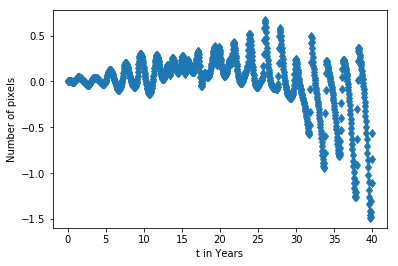

In [71]:
%%time
Furnisher('310+341+435')
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
xerr,yerr,times,distance,x,y = ErrorSource(['1','2','3','4','6','7','8','Jupiter','Io','Europa','Ganymede','Callisto','Magaclite'],[MMercuryB,MVenusB,MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,MCallisto,0 ],[9,10,11,12,13,14,15],'Magaclite','5')
temp = np.abs(xerr)
maxerr.append(np.max(temp))
temp = np.abs(distance)
distances.append(np.max(temp))
plt.plot(times/365.24,(xerr)*1e6/4.5,"d")
plt.ylabel("Number of pixels")
plt.xlabel("t in Years")

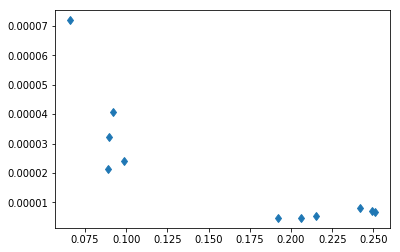

In [73]:
plt.plot(distances,maxerr,"d")